In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, MOD_SPECIFIC_IMAGES, MOD_SPECIFIC_CAPTIONS
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

# Zero-shot cross-modal decoding

In [2]:
all_data = load_results_data()

100%|██████████| 100/100 [00:01<00:00, 59.86it/s]


In [3]:
MODEL_ORDER = ["random-flava", "clip", "flava", "imagebind"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]
all_data

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.872143,clip_avg
1,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.862653,clip_avg
2,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.924286,clip_avg
3,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.893469,clip_avg
4,100000.0,clip,sub-01,concat,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.875918,clip_concat
...,...,...,...,...,...,...,...,...,...,...,...
275,100000.0,flava,sub-05,matched,visual_feature_cls,images,whole_brain,188225,pairwise_acc_mean,0.789388,flava_matched
276,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.809490,flava_matched
277,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.726122,flava_matched
278,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939796,flava_matched


In [10]:
data_default_vision_feats = all_data.copy()
for model in all_data.model.unique():
    default_vision_feats = get_default_vision_features(model)
    data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
data_default_vision_feats

Selected default vision features for clip: visual_feature_cls
Selected default vision features for flava: visual_feature_cls
Selected default vision features for imagebind: visual_feature_cls


,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.872143,clip_avg
1,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.862653,clip_avg
2,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.924286,clip_avg
3,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.893469,clip_avg
4,100000.0,clip,sub-01,concat,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.875918,clip_concat
...,...,...,...,...,...,...,...,...,...,...,...
275,100000.0,flava,sub-05,matched,visual_feature_cls,images,whole_brain,188225,pairwise_acc_mean,0.789388,flava_matched
276,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.809490,flava_matched
277,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.726122,flava_matched
278,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939796,flava_matched


In [11]:
data_matched_feats = data_default_vision_feats[data_default_vision_feats.features == "matched"]
data_matched_feats

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
8,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.860510,clip_matched
9,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.857551,clip_matched
10,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.918163,clip_matched
11,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.887857,clip_matched
20,100000.0,flava,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.877143,flava_matched
...,...,...,...,...,...,...,...,...,...,...,...
275,100000.0,flava,sub-05,matched,visual_feature_cls,images,whole_brain,188225,pairwise_acc_mean,0.789388,flava_matched
276,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.809490,flava_matched
277,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.726122,flava_matched
278,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939796,flava_matched


In [44]:
# add oks/zero_shot_cross_modal_de #TODO not necessary?!
extra_rows = []
for model in data_matched_feats.model.unique():
    for subject in SUBJECTS:
        data_model_subj = data_matched_feats[(data_matched_feats.model == model) & (data_matched_feats.subject == subject)]
        # cross-modal
        cross_modal_train_images_eval_captions = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_CAPTIONS)]
        cross_modal_train_captions_eval_images = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_IMAGES)]

        if len(cross_modal_train_images_eval_captions) > 0:
            assert len(cross_modal_train_images_eval_captions) == len(cross_modal_train_captions_eval_images) == 1
            mean_acc = (cross_modal_train_images_eval_captions.value.item() + cross_modal_train_captions_eval_images.value.item()) / 2
    
            mean_row = cross_modal_train_images_eval_captions.copy()
            mean_row["training_mode"] = "cross-modal"
            mean_row["metric"] = "mean"
            mean_row["value"] = mean_acc
            mean_row["condition"] = "cross-modal"

            extra_rows.append(mean_row)

        # within-modal
        within_modal_captions = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_CAPTIONS)]
        within_modal_images = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_IMAGES)]

        if len(within_modal_captions) > 0:
            assert len(within_modal_captions) == len(within_modal_images) == 1
            mean_acc = (within_modal_captions.value.item() + within_modal_images.value.item()) / 2
    
            mean_row = within_modal_captions.copy()
            mean_row["training_mode"] = "within-modal"
            mean_row["metric"] = "mean"
            mean_row["value"] = mean_acc
            mean_row["condition"] = "within-modal"

            extra_rows.append(mean_row)

extra_rows = pd.concat(extra_rows)
data_matched_with_mean = pd.concat((data_matched_feats, extra_rows), ignore_index=True)
data_matched_with_mean[data_matched_with_mean.metric == "mean"]

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat,condition
96,100000.0,flava,sub-01,matched,visual_feature_cls,cross-modal,whole_brain,162649,mean,0.726837,flava_matched,cross-modal
97,1000.0,flava,sub-01,matched,visual_feature_cls,within-modal,whole_brain,162649,mean,0.874898,flava_matched,within-modal
98,100000.0,flava,sub-02,matched,visual_feature_cls,cross-modal,whole_brain,172606,mean,0.678878,flava_matched,cross-modal
99,100000.0,flava,sub-02,matched,visual_feature_cls,within-modal,whole_brain,172606,mean,0.855714,flava_matched,within-modal
100,100000.0,flava,sub-03,matched,visual_feature_cls,cross-modal,whole_brain,188176,mean,0.707551,flava_matched,cross-modal
101,1000.0,flava,sub-03,matched,visual_feature_cls,within-modal,whole_brain,188176,mean,0.855306,flava_matched,within-modal
102,100000.0,flava,sub-04,matched,visual_feature_cls,cross-modal,whole_brain,226242,mean,0.695204,flava_matched,cross-modal
103,100000.0,flava,sub-04,matched,visual_feature_cls,within-modal,whole_brain,226242,mean,0.857041,flava_matched,within-modal
104,100000.0,flava,sub-05,matched,visual_feature_cls,cross-modal,whole_brain,188225,mean,0.687245,flava_matched,cross-modal
105,100000.0,flava,sub-05,matched,visual_feature_cls,within-modal,whole_brain,188225,mean,0.813878,flava_matched,within-modal


In [33]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

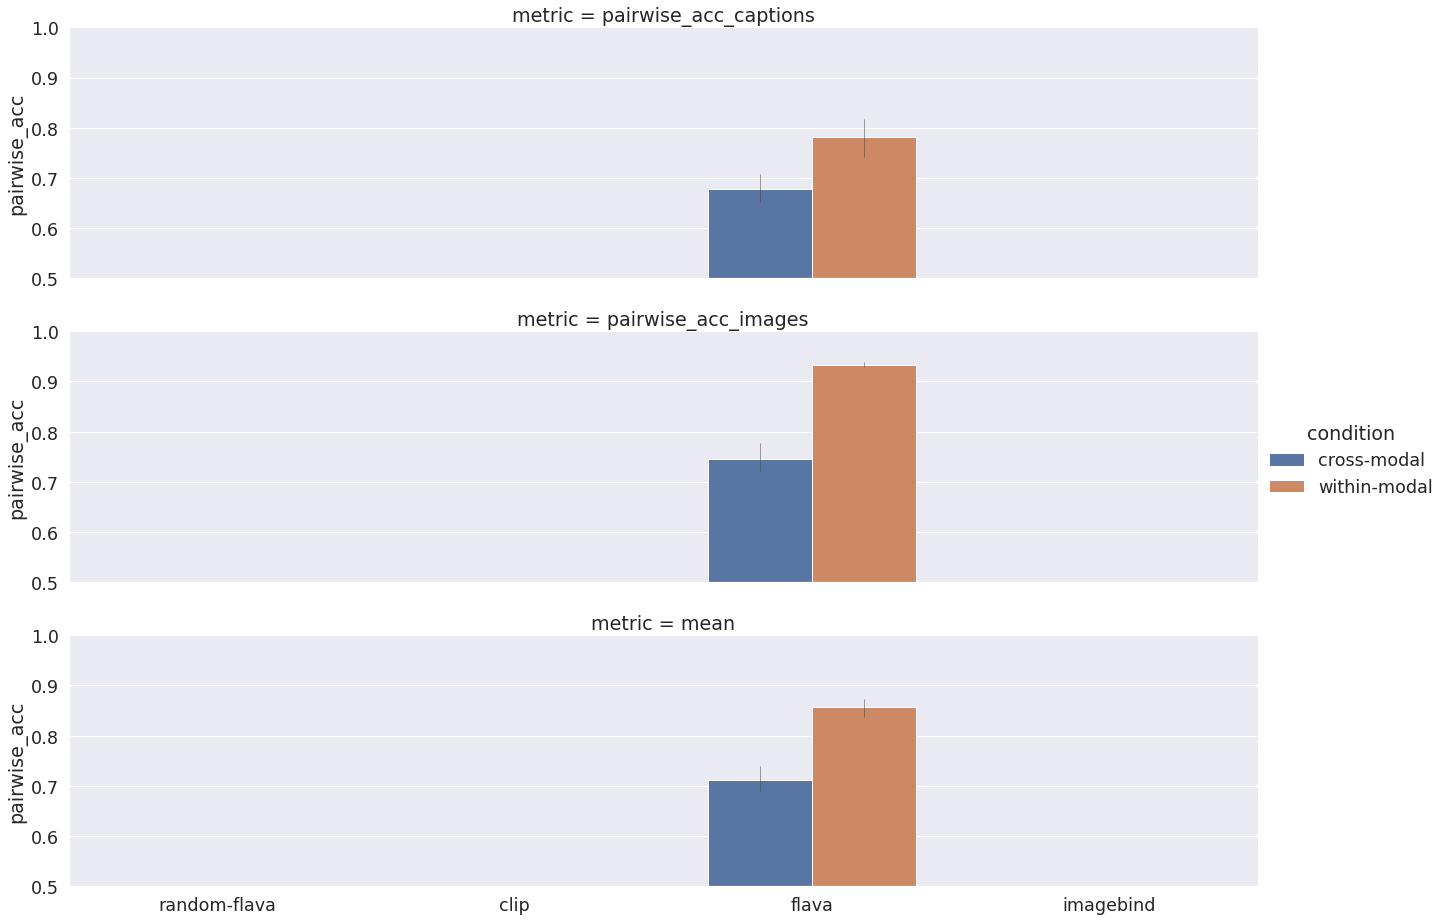

In [50]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_matched_with_mean.copy()

data_to_plot = data_to_plot[data_to_plot.training_mode != "modality-agnostic"]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

data_to_plot.loc[((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "cross-modal"
data_to_plot.loc[((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "within-modal"

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

# data_to_plot["metric"] = data_to_plot.metric.replace({ACC_CAPTIONS: "zero_shot_train_images_eval_captions", ACC_IMAGES: "zero_shot_train_captions_eval_images"})


metrics_order = [ACC_CAPTIONS, ACC_IMAGES, "mean"]

height = 4.5
aspect = 4

condition_order = ["cross-modal", "within-modal"]

for mode in ["captions", "images", "cross-modal", "within-modal"]:
    data_mode = data_to_plot[data_to_plot.training_mode == mode]
    for model in MODEL_ORDER:
        for condition in condition_order:
            length = len(data_mode[(data_mode.model == model) & (data_mode.condition == condition)])
            expected_num_datapoints = len(SUBJECTS)
            if length != expected_num_datapoints:
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {model} {mode})"
                print(f"Warning: {message}")
            
g = sns.catplot(data_to_plot, kind="bar", x="model", order=MODEL_ORDER, y="value", row="metric", row_order=metrics_order, col=None, height=height, aspect=aspect, hue="condition", hue_order=condition_order,
                palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
g.set(ylim=(0.5, 1), ylabel="pairwise_acc", xlabel='')





# figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_zero_shot_cross_modal_decoding.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [9]:
models = ["glow", "glow-contrastive"]
results_table = calc_zero_shot_scores(models)

plt.figure(figsize=(20, 10))
sns.barplot(data=results_table, x="metric", y="value", hue="model")
plt.ylim((0.4, 1))
plt.axhline(y=0.5, color="black")
plt.ylabel("pairwise accuracy")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "glow_zero_shot_cross_modal_decoding.png"), dpi=300, facecolor='white', transparent=False)

NameError: name 'calc_zero_shot_scores' is not defined

In [ ]:
models = ["random-flava", "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "lxmert", "vilt", "glow"]
results_table = calc_zero_shot_scores(models)

plt.figure(figsize=(20, 10))
sns.barplot(data=results_table, x="metric", y="value", hue="model")
plt.ylim((0.4, 1))
plt.axhline(y=0.5, color="black")
plt.ylabel("pairwise accuracy")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "zero_shot_cross_modal_decoding.png"), dpi=300, facecolor='white', transparent=False)

In [ ]:
IMAGE = "image"
CAPTION = "caption"


def pairwise_accuracy(latents, predictions, stimulus_ids, stim_types, metric="cosine", normalize=True):
    results = dict()

    for modality in [CAPTION, IMAGE]:
        preds_mod = predictions[stim_types == modality].copy()
        latents_mod = latents[stim_types == modality]
        if normalize:
            pred_mod_normalize = Normalize(preds_mod.mean(axis=0), preds_mod.std(axis=0))
            preds_mod = pred_mod_normalize(preds_mod)
    
        dist_mat = get_distance_matrix(preds_mod, latents_mod, metric)
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat
        results[f"pairwise_acc_{modality}s"] = comp_mat.mean()

    if normalize:
        pred_normalize = Normalize(predictions.mean(axis=0), predictions.std(axis=0))
        predictions = pred_normalize(predictions)

    dist_mat = get_distance_matrix(predictions, latents, metric)

    mod_agnostic_accs = []
    for modality in [CAPTION, IMAGE]:
        dist_mat_within_mod = dist_mat[stim_types == modality][:, stim_types == modality]

        dist_mat_cross_modal = dist_mat[stim_types == modality][:, stim_types != modality]
        dist_mat_min = np.min((dist_mat_within_mod, dist_mat_cross_modal), axis=0)
        diag = dist_mat_min.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat_min

        scores = np.mean(comp_mat, axis=0)
        mod_agnostic_accs.extend(scores)
        results[f"pairwise_acc_mod_agnostic_{modality}s"] = scores.mean()
        
    results[f"pairwise_acc_modality_agnostic"] = np.mean(mod_agnostic_accs)
    print(results)

    return results


In [ ]:
def get_scores(model, train_features, test_features, train_mode, test_mode):
    acc_scores = []
    results_all_subjects_train = load_results_files(model, train_features, train_mode)
    results_all_subjects_test = load_results_files(model, test_features, test_mode)
    assert len(results_all_subjects_train) == len(results_all_subjects_test)
    print(f"loaded results from {len(results_all_subjects_train)} subjects")
    for results_train, results_test in zip(results_all_subjects_train, results_all_subjects_test):
        preds = results_train[PREDS]
        
        targets = results_test[TARGETS]
        # acc_caps = pairwise_accuracy(targets[results_train[STIM_TYPES] == CAPTION], preds[results_train[STIM_TYPES] == CAPTION], results_train[STIM_IDS][results_train[STIM_TYPES] == CAPTION], results_train[STIM_TYPES][results_train[STIM_TYPES] == CAPTION])

        acc = pairwise_accuracy(targets, preds, results_train[STIM_IDS], results_train[STIM_TYPES])

        acc_scores.append(acc)
        return #TODO

    return acc_scores

def calc_zero_shot_scores(models):
    results = []
    for model in models: 
        scores_img_cap = get_scores(model, "matched", "matched", "train", "train")
    
models = ["glow-contrastive"]
results_table = calc_zero_shot_scores(models)


In [ ]:
#{'pairwise_acc_captions': 0.8042857142857143, 'pairwise_acc_mod_agnostic_captions': 0.8120408163265306, 'pairwise_acc_images': 0.9132653061224489,
# 'pairwise_acc_mod_agnostic_images': 0.9179591836734693, 'pairwise_acc_modality_agnostic': 0.8650000000000001}

#
{'pairwise_acc_captions': 0.7777551020408163, 'pairwise_acc_mod_agnostic_captions': 0.7761224489795918, 'pairwise_acc_images': 0.9202040816326531, 
 'pairwise_acc_mod_agnostic_images': 0.9210204081632651, 'pairwise_acc_modality_agnostic': 0.8485714285714285}
